# Modelling Afterpay's customer growth
> How can we model the growth in Afterpay's customer base?

- toc: true 
- badges: true
- comments: true
- categories: [Sympy,Finance,Afterpay]
    
- image: images/2020-08-13-Modelling-Afterpays-Customer-Growth/header.png

## The Context

The thesis of this post is actually pretty simple. There is a delay between when customers make a transaction, and when *Afterpay* realises that they have defaulted. Because of this delay, combined with the rapid growth in the total value of transactions, defaults as a percentage of transaction value may be artificially reduced. 





> Important:  Obviously I need a disclaimer. If you use anything I say as the basis for any decision, financial or otherwise, you are an idiot.


## The Model

First off, let's load in a bunch of libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from io import StringIO
import pandas as pd


import scipy.optimize

plt.rcParams["figure.figsize"] = (10,10)
from warnings import filterwarnings
filterwarnings('ignore')


While reading through Afterpay's releases to the markets, I came across this chart, which appears on page 3 of [this](https://www.afterpaytouch.com/images/APT_ASX-Announcement_Q2-FY18_16-Jan-Final-2.pdf) release.


![Image of Afterpay custmer growth](../images/2020-08-13-Modelling-Afterpays-Customer-Growth/CustomerGrowth.png)


## Loading the data

In [2]:
#Underlying sales
csv_data = StringIO('''anz_underlying_sales_value,date,month_count
0,FY15,0
37.3,FY16,12
561.2,FY17,24
2184.6,FY18,36
4314.1,FY19,48
6566.9,FY20,60''')

df = pd.read_csv(csv_data, sep=",")

## Fitting a curve

[  2.17012649 -17.61639881 -58.725     ]


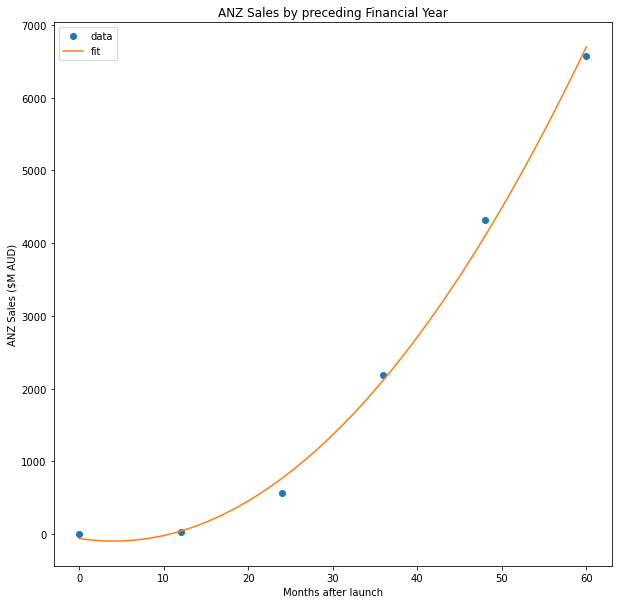

In [3]:
def quadratic(t, a, b, c):
    y = a * t**2 + b * t + c
    return y

xdata = df.month_count.values
ydata = df.anz_underlying_sales_value.values

popt, pcov = scipy.optimize.curve_fit(quadratic, xdata, ydata)


print(popt)
x = np.linspace(0,60, 61)
y = quadratic(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.plot(x,y, label='fit')

plt.title('ANZ Sales by preceding Financial Year ($M AUD)')
plt.xlabel('Months after launch')
plt.ylabel('ANZ Sales ($M AUD)')
plt.legend(loc='best')
plt.show()

Ok, let's pause for a moment, and actually think about what this curve represents.

It's the sum, or integral of the total sales for the preceding 1 year period. 

Now, let's find the underlying function which is being integrated, which will give us a more accurate picture of the growth in sales at any point in time.

Later in the article, we will find this function, but for now let's just stay focused on understanding how delays in recognising defaults, affect effective default rates. 

## Some Algebra


So we found that we could model the annual reported sales as: $$2.170 t^2 - 17.61t - 58.725$$ 

The instantanious rate of sales, is given by : $$0.1808t^2 + 0.7021t -9.36$$.

Don't wory how I arrived, I will show how in in the appendix of this post.


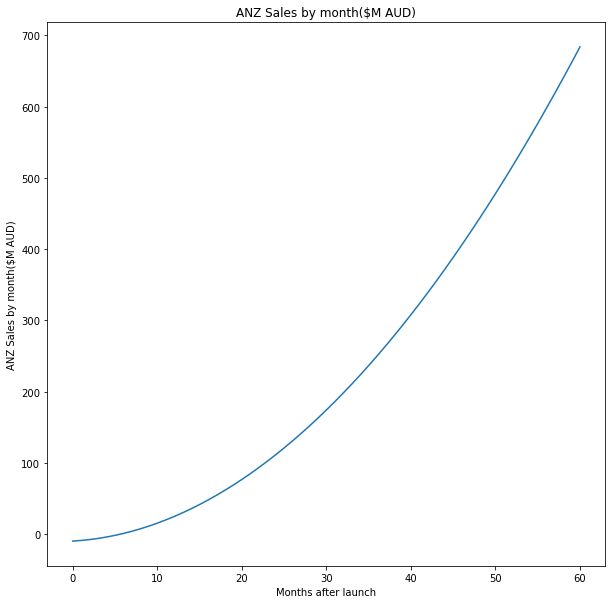

In [22]:
t = np.linspace(0,60, 61)
sales = 0.1808*t**2 + 0.7021* t - 9.36

plt.plot(sales)

plt.title('ANZ Sales by month ($M AUD)')
plt.xlabel('Months after launch')
plt.ylabel('ANZ Sales by month ($M AUD)')
plt.show()

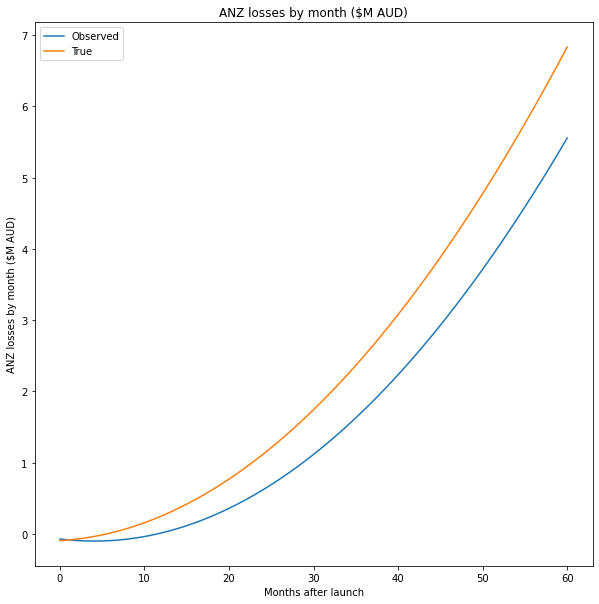

In [36]:
delay = 6 #months 
true_loss_rate = 0.01

losses_true = true_loss_rate*(0.1808*t**2 + 0.7021* t - 9.36)
losses_observed = true_loss_rate*(0.1808*(t-delay)**2 + 0.7021* (t-delay) - 9.36)
plt.plot(losses_observed,label='Observed')
plt.plot(losses_true,label='True')

plt.legend()
plt.title('ANZ losses by month ($M AUD)')
plt.xlabel('Months after launch')
plt.ylabel('ANZ losses by month ($M AUD)')
plt.show()

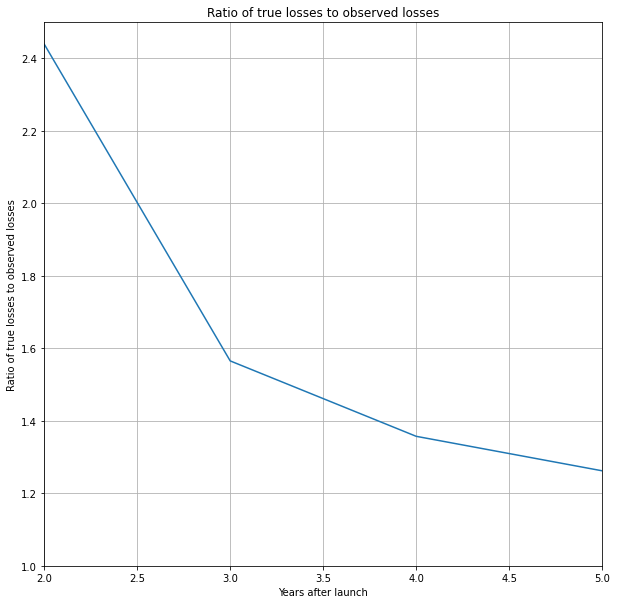

In [49]:
def integrate_by_year(y):
    integrated = np.array([0,np.sum(y[0:12]),np.sum(y[12:24]),np.sum(y[24:36]),np.sum(y[36:48]),np.sum(y[48:60])])
    return(integrated)


observed_loss_rate = integrate_by_year(losses_true)/integrate_by_year(losses_observed)

plt.plot(observed_loss_rate)

plt.title('Ratio of true losses to observed losses')
plt.xlabel('Years after launch')
plt.ylabel('Ratio of true losses to observed losses')
plt.ylim(1,2.5)
plt.xlim(2,5)
plt.grid()
plt.show()

## Conclusion
In conclusion, we can clearly see the impact of a delay in recognising losses, in situations where there is rapid growth. Even after years of growth, with a 6 month delay in recognising losses, the true losses could be 30-40% higher than reported.


# Appendix

## Some Algebra

To help us with the algebraic manipulation, we can use [Sympy](https://docs.sympy.org/latest/index.html). An alternative is to do the algebraic manipulation by hand, but this is probably faster and more scalable.



### Finding an integral


So we found that we could model the annual reported sales as: $$2.170 t^2 - 17.61t - 58.725$$ 

Let's call this function $f(t)$

We want to find the function $g(t)$, where: 




In [4]:
import sympy as sym
sym.init_printing(use_unicode=True)

a,b,c,d,t = sym.symbols('a b c d t')

expr = sym.simplify((a*t**3 + b*t**2 + c*t + d) - (a*(t-12)**3 + b*(t-12)**2 + c*(t-12) + d))  

In [5]:
print(sym.collect(expr,t))

36*a*t**2 + 1728*a - 144*b + 12*c + t*(-432*a + 24*b)


In [6]:
fitted_quadratic = t**2 * 2.17012649 + t*-17.61639881 -58.725

### Solving for the coefficients

In [7]:
equations = []
for i in [2,1,0]:
    eq = sym.collect(expr,t).coeff(t, i)
    coeff = sym.collect(fitted_quadratic,t).coeff(t, i)
    equations.append(sym.Eq(eq,coeff))

result = sym.solve(equations,(a,b,c))

print(result)

{a: 0.0602812913888889, b: 0.351046627916667, c: -9.36169642500000}


## Plotting the results

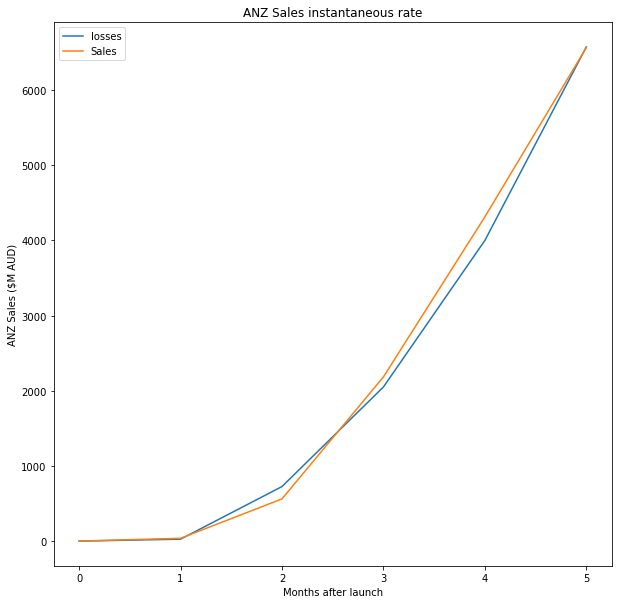

In [8]:

t = np.linspace(0,60, 61)
y = 3 * result[a] * t**2 + 2 * result[b]*t + result[c]

integrated = np.array([0,np.sum(y[0:12]),np.sum(y[12:24]),np.sum(y[24:36]),np.sum(y[36:48]),np.sum(y[48:60])])

plt.plot(integrated,label='losses')

plt.plot(df.anz_underlying_sales_value.values,label='Sales')

plt.title('ANZ Sales instantaneous rate')
plt.xlabel('Months after launch')
plt.ylabel('ANZ Sales ($M AUD)')
plt.legend(loc='best')
plt.show()



In [9]:
sym.diff(fitted_quadratic)

[-12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.]
[-12   0  12  24  36  48]


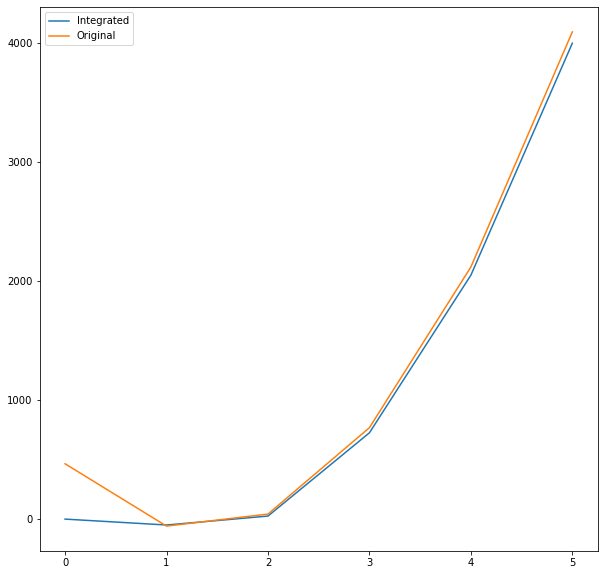

In [10]:
t = np.linspace(0,60, 61) - 12
y = 3 * result[a] * t**2 + 2 * result[b]*t + result[c]
integrated = np.array([0,np.sum(y[0:12]),np.sum(y[12:24]),np.sum(y[24:36]),np.sum(y[36:48]),np.sum(y[48:60])])

t = np.arange(0,72,12) - 12

y = quadratic(t, *popt)

plt.plot(integrated,label='Integrated')
plt.plot(y,label='Original')
plt.legend()
plt.show()